2022年香港中文大学的论文《Are Transformers Effective for Time Series Forecasting?》仅仅用最简单的Linear模型就结结实实的打脸了一众Transformer-based 模型，

最尴尬的是，在汇率预测上，一个简单的用昨天预测今天，或者上一个周期预测下一个周期的策略竟然比所有Transformer模型都表现得更好。这不禁让人怀疑，这些所谓的Transformer based究竟是在真的学习序列特征，还是只是在过拟合噪声，然后选择拟合的比较好的那些发表。

Transformer在NLP中的成功是基于其提取序列元素间语义相关性的能力。然而，时间序列数据本身通常缺乏语义，其核心在于建模连续点集中的时间关系，其中序列本身扮演着最关键的角色。

在自然语言中，即使完全打乱单词顺序，单纯的词义就可以反映相当多的原句的语义，Tramsformer模型再利用位置编码，建模词义之间的相对关系所带来的深层词义，来完成整个句子语义的处理。虽然位置编码可以保留一部分序列信息，但总归是有转换和丢失的。

面对时序数据，一个完全被打乱的序列，几乎丢掉了99%的信息，换言之时序数据的信息大部分都隐藏在相关关系中。在这种情况下，再去强行追求former系的并行性，用低效率的位置编码尝试保留序列信息，相当于是买椟还珠，本末倒置了。堆叠各种复杂的模型，并不一定就能取得更优的效果，更多只是基于发论文视角的为了创新而创新。

因此，在dive into deep learning 的各种 “former” 之前，需要先用传统的统计学工具建立一个科学而合理的基线模型，来区分哪些是真正有价值的，哪些只是花里胡哨的。



我们结合前述的所有框架，采用最简单的线性模型DLinear作为编码器，建立一个基线模型

在随机选取的数据区间和随机训练上，得到了平均7.70% (std 4.78%) 的超额预测准确率：即在做出预测的情况下（分类0 和分类2中），预测正确的概率超出预测完全错误的比例。

例如，模型做出了100个激进的有方向的预测（即产生了交易）其中有50个实际结果为分类1（即震荡市场），30个预测正确，20个预测错误，那么超额的正确率就是10%。

这个数字可以作为一个良好的模型评估基准，如果更为复杂的模型的准确率没有这样的效果，那就不得不思考当前的模型是否有效了

In [1]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from scipy.stats import norm, t

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain

In [3]:
import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

In [4]:
feature = ['log_open','log_high','log_low','log_close','log_amount']
label = ['label_return','down_prob','middle_prob','up_prob']

In [5]:
start_date = '20150101'
split_date = '20200101'
end_date = '20250101'

In [6]:
window_size = 40
pred_len = 5

In [7]:
future_list = pro.fut_basic(fut_type='2')
future_list

,ts_code,symbol,exchange,name,fut_code,multiplier,trade_unit,per_unit,quote_unit,quote_unit_desc,d_mode_desc,list_date,delist_date,d_month,last_ddate
0,CFE_LL161MSF.WI,CFE_LL161MSF,None,上证50当月合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
1,CFE_LL161QSF.WI,CFE_LL161QSF,None,上证50当季合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
2,CFE_LL162MSF.WI,CFE_LL162MSF,None,上证50下月合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
3,CFE_LL162QSF.WI,CFE_LL162QSF,None,上证50下季合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
4,CFE_LL163MSF.WI,CFE_LL163MSF,None,上证50下下月合成期货,HO.CFE,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,IML3.CFX,IML3,CFFEX,中证1000期货下季连续,IM,None,None,None,None,None,None,None,None,None,None
207,TLL.CFX,TLL,CFFEX,30年期国债期货当季连续,TL,None,None,None,None,None,None,None,None,None,None
208,TLL1.CFX,TLL1,CFFEX,30年期国债期货下季连续,TL,None,None,None,None,None,None,None,None,None,None
209,TLL2.CFX,TLL2,CFFEX,30年期国债期货隔季连续,TL,None,None,None,None,None,None,None,None,None,None


In [8]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'CF.ZCE', 'RB.SHF','HC.SHF']
# assets_list = ['000016.SH', '000300.SH', '000905.SH']

In [9]:


train_set = None
validation_set = None
for code in assets_list:
    data = pro.fut_daily(ts_code = code, start_date = start_date, end_date = split_date)
    data['oi_chg'] = 1
    data.sort_values(by = 'trade_date', inplace = True)
    data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 #标准化为对数百分比（不含百分号）
    data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
    data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
    data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
    data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

    data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len) # 标准化为对数百分比（不含百分号），可以直接相加
    data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len)/data['amount'].mean() * data['label_return'].std()

    threshold = (abs(data['label_return'].quantile(0.75)) + abs(data['label_return'].quantile(0.25)))/2
    amount_mean = data['amount'].mean()
    return_std = data['label_return'].std()

    def down_probability(row):
        return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def middle_probability(row):
        return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def up_probability(row):
        return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
    
    data['down_prob'] = data.apply(down_probability, axis = 1)
    data['middle_prob'] = data.apply(middle_probability, axis = 1)
    data['up_prob'] = data.apply(up_probability, axis = 1)
    data.dropna(inplace=True)

    feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
    feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

    label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
    label_tensor = label_tensor[window_size-1:]

    if train_set == None:
    
        train_set = CallableDataset(feature_tensor, label_tensor)
    else:
        train_set = train_set + CallableDataset(feature_tensor, label_tensor)

    

    data = pro.fut_daily(ts_code = code, start_date = split_date, end_date = end_date)
    data['oi_chg'] = 1
    data.sort_values(by = 'trade_date', inplace = True)
    data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 
    data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
    data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
    data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
    data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

    data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len)
    data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len) / amount_mean * return_std

    def down_probability(row):
        return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def middle_probability(row):
        return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

    def up_probability(row):
        return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
    
    data['down_prob'] = data.apply(down_probability, axis = 1)
    data['middle_prob'] = data.apply(middle_probability, axis = 1)
    data['up_prob'] = data.apply(up_probability, axis = 1)
    data.dropna(inplace=True)

    threshold_test = (abs(data['label_return'].quantile(0.75)) + abs(data['label_return'].quantile(0.25)))/2

    print(f'{code}: train threshold: {threshold:.2f}, test threshold: {threshold_test:.2f}')

    # print(f'train: {threshold:.2f}, {amount_mean:.2f}, {return_std:.2f}')
    # print(f'test :{threshold_test:.2f}, {data['amount'].mean():.2f}, {data['label_return'].std():.2f}')

    feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
    feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

    label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
    label_tensor = label_tensor[window_size-1:]

    if validation_set == None:
    
        validation_set = CallableDataset(feature_tensor, label_tensor)
    else:
        validation_set = validation_set + CallableDataset(feature_tensor, label_tensor)

IH.CFX: train threshold: 1.66, test threshold: 1.59
IF.CFX: train threshold: 1.85, test threshold: 1.59
IC.CFX: train threshold: 2.19, test threshold: 1.59
CF.ZCE: train threshold: 1.40, test threshold: 1.63
RB.SHF: train threshold: 2.37, test threshold: 2.00
HC.SHF: train threshold: 2.14, test threshold: 1.95


In [10]:
test_set = validation_set

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size):
        super(DLinear, self).__init__()

        self.seq_len = seq_len # 输入序列的长度
        self.pred_len = pred_len # 预测序列的长度

        # Decompsition Kernel Size
        self.kernel_size = kernel_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual # 是否为每个feature应用不同的参数
        self.channels = enc_in # feature的个数 例如OHLCV数据为5

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))

        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            
    def forward(self, x):
        # x: [Batch, Input length, Channel]

        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]


In [12]:
class DLinearOutput(nn.Module):
    """循环神经网络模型"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, dropout, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'

        self.process = nn.Sequential(
            DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size),
            nn.Sequential(nn.Flatten(start_dim = 1), nn.Dropout(dropout))
            )

        # self.process = nn.Sequential(
        #     nn.Flatten(start_dim = 1),
        #     nn.Linear(enc_in * seq_len, 20), nn.ReLU(), nn.Dropout(dropout),
        #     nn.Linear(20, 5), nn.ReLU(), nn.Dropout(dropout),
        #     )

        self.output = HybridDecoder(pred_len * enc_in, init_prob = init_prob)

    def forward(self, x):
        x = self.process(x)
        return self.output(x)

In [13]:
recorder = PredictionRecorder(is_logits = True)
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [14]:
# model = DLinearOutput(seq_len = 30, pred_len = 5, individual = True, enc_in = 5, kernel_size = 11, init_prob = [0.0, 1, 0.0]).to('cuda:0')

# loss_fn = HybridLoss(alpha = 1e-3, delta = 1)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay = 1e-1)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# train = ModelTrain(model = model,
#                    train_set = train_set,
#                    validation_set=validation_set,
#                    test_set=test_set,
#                    loss_fn = loss_fn,
#                    optimizer = optimizer,
#                    scheduler=scheduler,
#                    recorder=recorder,
#                    graph=animator,
#                    threshold = 45,
#                    )
# train.epoch_train(epochs = 20, round = 100, early_stop = 30)

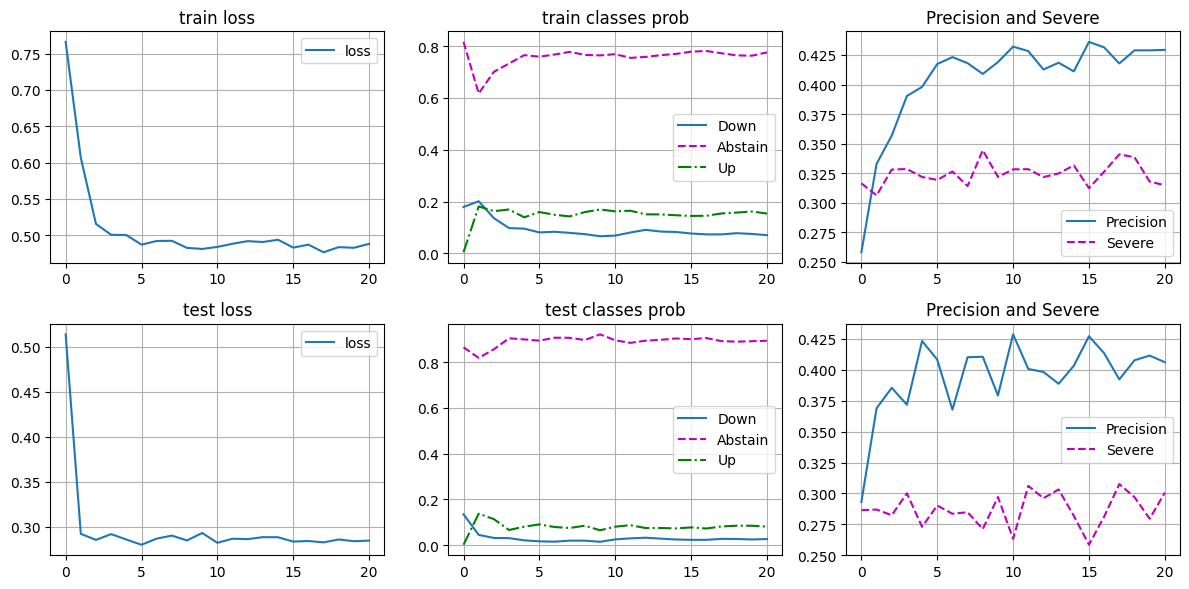

100%|██████████| 100/100 [00:00<00:00, 303.80it/s]


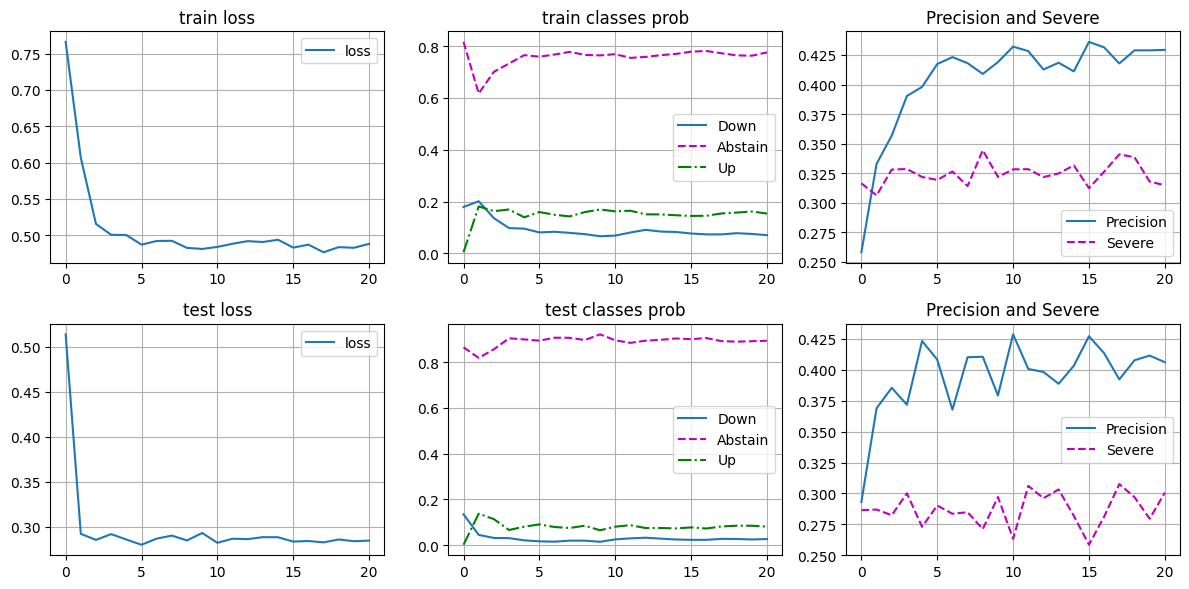

In [15]:
gap = []
for i in range(10):
    
    animator.reset()
    loss_fn = HybridLoss(alpha = 1e-3, delta = 1)
    model = DLinearOutput(seq_len = 40, pred_len = 5, individual = True, enc_in = 5, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
    train = ModelTrain(model = model,
                       batch_size = 100,
                   train_set = train_set,
                   validation_set=validation_set,
                   test_set=test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   threshold = 1.5,
                   )
    precision, severe = train.epoch_train(epochs = 20, round = 100, early_stop = 100)

    gap.append(precision - severe)


In [16]:
print(f'超额正确率均值  ：{np.mean(gap):.2%}')
print(f'超额正确率标准差：{np.std(gap):.2%}')

超额正确率均值  ：11.38%
超额正确率标准差：2.16%


In [17]:
# torch.save(model.state_dict(), 'params/baseline.params')

In [18]:
print(BackTest(model, *train_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'train', print_summary = True)

yearly return :7.75%
std           :5.56%
sharpe ratio  :0.85


100%|██████████| 100/100 [00:00<00:00, 297.90it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),6.11%,49.43%,26.84%,28.25%,10.69%
分类 1 (放弃),78.53%,46.52%,0.00%,40.67%,89.82%
分类 2 (乐观),15.36%,48.37%,34.11%,31.08%,23.91%
分类 0 + 分类 2,21.47%,48.67%,32.04%,59.33%,17.61%


In [19]:
print(BackTest(model, *validation_set.all(),sliding_window=5,init_value=3000))
train.round(round = 100, is_train = False, use_set = 'validation', print_summary = True)

yearly return :1.24%
std           :2.78%
sharpe ratio  :-0.63


100%|██████████| 100/100 [00:00<00:00, 294.93it/s]


,Prediction Ratio,Precision: Right/Pred,Severe: Wrong/Pred,Real Ratio,Accuracy: Right/Real
分类 0 (悲观),2.32%,36.64%,26.29%,25.84%,3.29%
分类 1 (放弃),89.62%,46.42%,0.00%,45.03%,92.38%
分类 2 (乐观),8.06%,42.56%,25.56%,29.13%,11.77%
分类 0 + 分类 2,10.38%,41.23%,25.72%,54.97%,7.79%
